# Visualize a simulation

In this tutorial you will learn how to display a simulated world as SVG or HTML in a notebook cell and how to keep the visualization synchronized.

Let's start by definining an experiment with different types of agents

In [1]:
from navground import sim, core

yaml = """
type: Cross
agent_margin: 0.1
side: 4
target_margin: 0.1
tolerance: 0.5
groups:
  -
    type: thymio
    number: 10
    radius: 0.08
    color: "#e6e6e6"
    kinematics:
      type: 2WDiff
      wheel_axis: 0.094
      max_speed: 0.166
    behavior:
      type: HL
      optimal_speed: 0.12
      horizon: 5.0
      safety_margin: 0.02
      barrier_angle: 1.4
    state_estimation:
      type: Bounded
      range: 5.0     
  -
    type: agent
    number: 10
    radius: 
        sampler: uniform
        from: 0.05
        to: 0.2
    kinematics:
      type: Ahead
      max_speed: 0.3
      max_angular_speed: 1.0
    color: "gold"
    behavior:
      type: HL
      optimal_speed: 0.15
      horizon: 5.0
      safety_margin: 0.1
      barrier_angle: 1.4
    state_estimation:
      type: Bounded
      range: 5.0   
"""
scenario = sim.load_scenario(yaml)

from which we initialize a world with a random seed:

In [2]:
import random

world = sim.World()
scenario.init_world(world, seed=random.randint(0, 2**31))

We can display the initial world state as a SVG

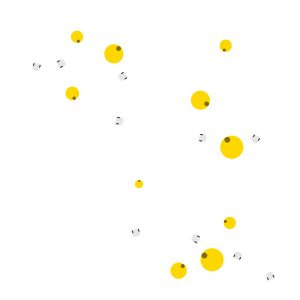

In [3]:
from IPython.display import SVG
from navground.sim.ui import svg_for_world

SVG(data=svg_for_world(world, width=300, bounds=((-2, -2), (2, 2))))

or as a HTML embedding the same SVG drawing

In [4]:
from IPython.display import HTML
from navground.sim.ui import html_for_world

data = html_for_world(world, width=300, bounds=((-2, -2), (2, 2)))
HTML(data=data)

which we can also save to a file

In [5]:
with open('test.html', 'w') as f:
    f.write(data)

and reload from that file

In [6]:
HTML(filename="test.html")

Let's run a simulation for a while and then visualize the new world state

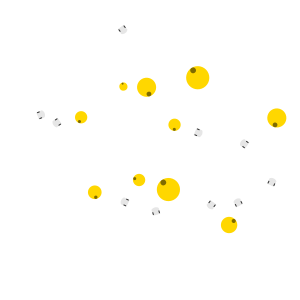

In [7]:
world.run(steps=100, time_step=0.1)

SVG(data=svg_for_world(world, width=300, bounds=((-2, -2), (2, 2))))

We can color the robot by their estimated time to the target.

Let's start by defining a function that maps a value in interval [a, b] to a color, using one of matplotlib color maps

In [8]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

def linear_map(a, b, cmap):
    c = cmx.ScalarMappable(norm=colors.Normalize(vmin=a, vmax=b), cmap=cmap)  
    def f(v):
        r, g, b, _ = c.to_rgba(v)
        return f"#{int(r * 255):02x}{int(g * 255):02x}{int(b * 255):02x}"
    return f

Then we decorate the SVG ``fill`` with colors generate from the estimated times until arrival (green=almost arrived, red=still far away). Decorations are functions that map an entiry (agents, obstacles, ...) to a dictionary of SVG [style] attributes.

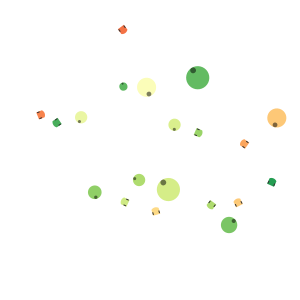

In [9]:
fill_map = linear_map(0, 40.0, cmap=cmx.RdYlGn_r)

def decorate(agent):
    t = agent.behavior.estimate_time_until_target_satisfied()
    return {"fill": fill_map(t)}

SVG(data=svg_for_world(world, width=300, decorate=decorate, bounds=((-2, -2), (2, 2))))

We can also update the same view. For this we need to instantiate an empty canvas

In [10]:
from navground.sim.ui import notebook_view

notebook_view(width=300, port=8002)

and a ``WebUI`` to keep it in sync via websockets

In [11]:
from navground.sim.ui import WebUI

ui = WebUI(port=8002)
await ui.prepare()

True

Let's now populate the view withe the current simulation state

In [12]:
await ui.init(world)

We can change attributes on the fly. For example, let's color all large agents in red

In [13]:
for a in world.agents:
    if a.radius > 0.15:
        await ui.set(a, style="fill:red")

Let's run the simulation futher and update the view

In [14]:
world.run(steps=100, time_step=0.1)
await ui.update(world)

In a interative way, by iterating running and update, 
we could display a live simulation, which is what `RealTimeSimulation` does automatically for us.

In [15]:
from navground.sim.real_time import RealTimeSimulation

In [16]:
rt = RealTimeSimulation(world=world, time_step=0.1, factor=4.0, 
                        web_ui=ui, bounds=((-2, -2), (2, 2)))

Multiple views are supported. Let's add one here to avoid scrolling up. 

In [17]:
notebook_view(width=300, port=8002)

In [18]:
await rt.run(until=lambda: world.time > 60)

Finally, let's color the agents by their efficacy (green=max, red=min efficacy) and run the simulation for one more minute:

In [19]:
fill_map = linear_map(0.0, 1.0, cmap=cmx.RdYlGn)

def f(entity):
    if isinstance(entity, sim.Agent):
        return {'fill': fill_map(entity.behavior.efficacy)}
    return {}

ui.decorate = f

In [20]:
await rt.run(until=lambda: world.time > 120)

We can also display a video instead of a live simulation. You need to install `cairosvg` (to render SVGs) and `moviepy` (to generate the videos)

```
pip install cairosvg moviepy
```

In [21]:
from navground.sim.ui.video import display_video

display_video(world, time_step=0.1, duration=30.0, factor=5.0, 
              bounds=((-2.5, -2.5), (2.5, 2.5)), decorate=f, display_width=300)

Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


or record a video to a file

In [22]:
from navground.sim.ui.video import record_video

record_video("test.mp4", world, time_step=0.1, duration=30.0, factor=5.0, 
              bounds=((-2.5, -2.5), (2.5, 2.5)), decorate=f, width=600)

Moviepy - Building video test.mp4.
Moviepy - Writing video test.mp4



Moviepy - Done !
Moviepy - video ready test.mp4


In [23]:
from IPython.display import Video

Video("test.mp4", width=300)